In [1]:
#https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from sklearn.decomposition import PCA

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.shape

(1458644, 11)

In [4]:
test.shape

(625134, 9)

In [5]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [6]:
print ("No need to worry about missing value") if train.count().min()==train.shape[0] else print(" Missing values present")

No need to worry about missing value


In [7]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [8]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)
train.loc[:,'pickup_date']=train.pickup_datetime.dt.date
train.store_and_fwd_flag=1*(train.store_and_fwd_flag.values=='Y')

test.pickup_datetime=pd.to_datetime(test.pickup_datetime)
test.loc[:,'pickup_date']=test.pickup_datetime.dt.date
test.store_and_fwd_flag=1*(test.store_and_fwd_flag.values=='Y')

In [9]:
train.check_trip_duration=(train.dropoff_datetime-train.pickup_datetime).map(lambda x:x.total_seconds())
duration_diff=train[np.abs(train.trip_duration.values-train.check_trip_duration.values)>1]
print('Trip duration times are good...') if duration_diff.shape[0]==0 else print('OOps')

Trip duration times are good...


In [10]:
train['trip_duration'].max()//3600

979

In [11]:
train['log_trip_duration']=np.log(train.trip_duration.values+1)

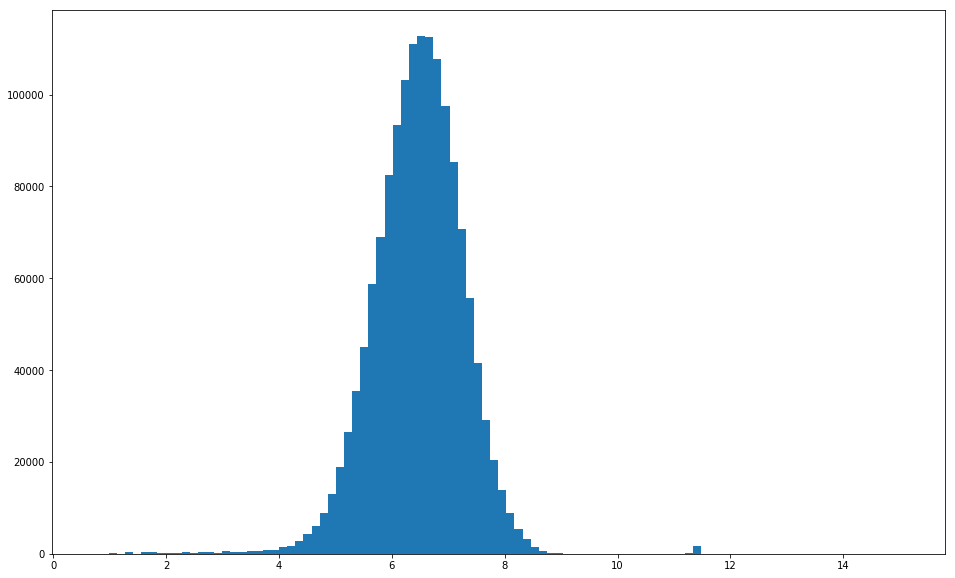

In [12]:
plt.hist(train['log_trip_duration'].values,bins=100)
plt.show()


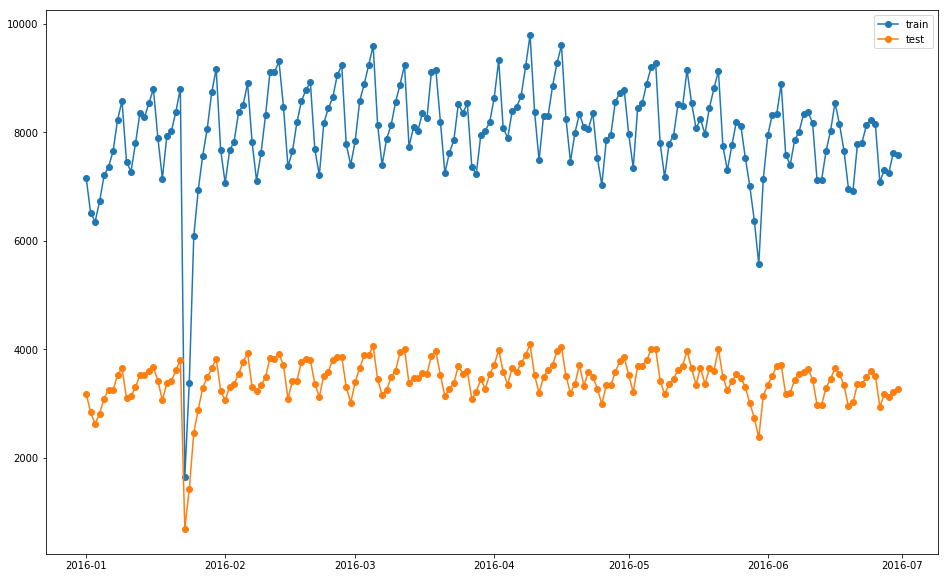

In [13]:
plt.plot(train.groupby('pickup_date').count()['id'],'o-',label='train')
plt.plot(test.groupby('pickup_date').count()['id'],'o-',label='test')
plt.legend(loc=0)
plt.figure(figsize=(5,1))
plt.show()

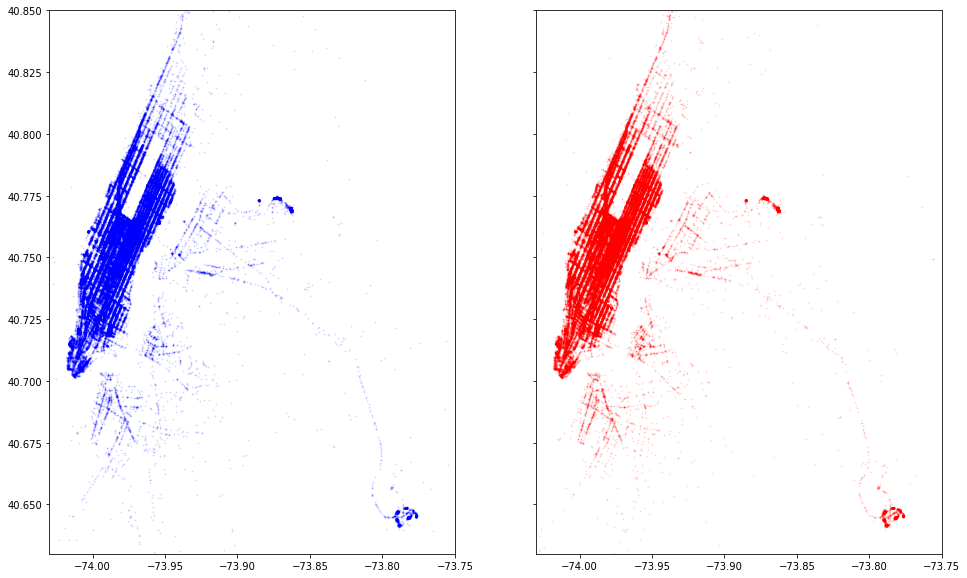

In [14]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig,ax=plt.subplots(ncols=2,sharex=True,sharey=True)
N=100000
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue',label='train')
ax[1].scatter(test['pickup_longitude'].values[:N],test['pickup_latitude'].values[:N],s=1,alpha=.1,color='red',label='test')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [15]:
#Feature extraction
#PCA
coords=np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                  train[['dropoff_latitude','dropoff_longitude']].values,
                 test[['pickup_latitude','pickup_longitude']].values,
                 test[['dropoff_latitude','dropoff_longitude']].values))
pca=PCA().fit(coords)

train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]


test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]

(-0.13426186697746503, 0.1017816834266389)

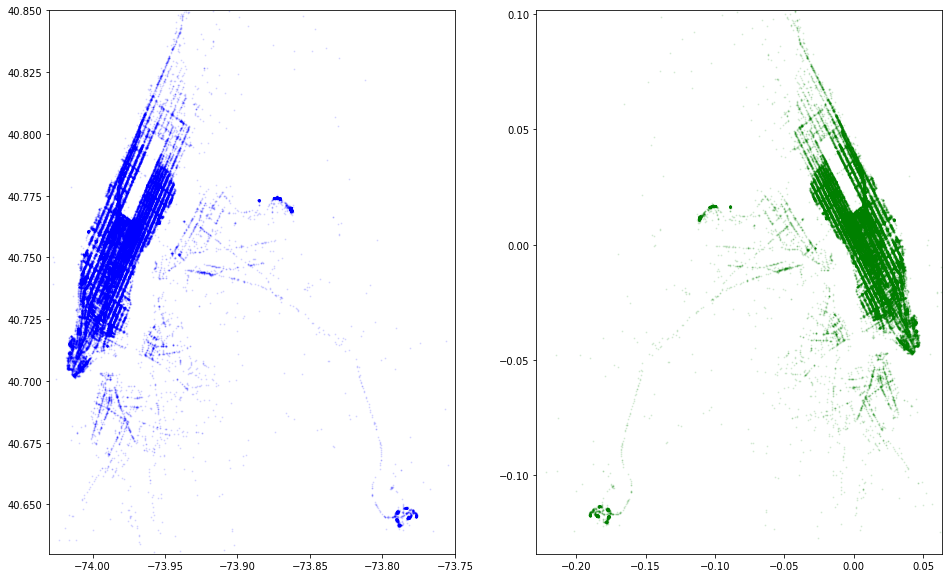

In [16]:
fig,ax=plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],s=1,alpha=.1,color='blue')
ax[1].scatter(train['pickup_pca0'].values[:N],train['pickup_pca1'].values[:N],s=1,alpha=.1,color='green')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders=pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(),pca_borders[:,0].max())
ax[1].set_ylim(pca_borders[:,1].min(),pca_borders[:,1].max())

In [17]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [23]:
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                  train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                                                 train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values,train['pickup_longitude'].values,
                                      train['dropoff_latitude'].values,train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])

In [24]:
test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                  test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                                                 test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values,test['pickup_longitude'].values,
                                      test['dropoff_latitude'].values,test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])

In [28]:
train.loc[:,'center_latitude']=(train['pickup_latitude'].values+train['dropoff_latitude'].values)/2
train.loc[:,'center_longitude']=(train['pickup_longitude'].values+train['dropoff_longitude'].values)/2
test.loc[:,'center_latitude']=(test['pickup_latitude'].values+test['dropoff_latitude'].values)/2
test.loc[:,'center_longitude']=(test['pickup_longitude'].values+test['dropoff_longitude'].values)/2

In [29]:
#Datetime Features

In [41]:
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_weekofyear']=train.pickup_datetime.dt.weekofyear
train.loc[:,'pickup_hour']=train.pickup_datetime.dt.hour
train.loc[:,'pickup_minute']=train.pickup_datetime.dt.minute
train.loc[:,'pickup_weekhour']=(train.pickup_datetime.dt.weekday*24)+train.pickup_datetime.dt.hour

In [42]:
test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'pickup_weekofyear']=test.pickup_datetime.dt.weekofyear
test.loc[:,'pickup_hour']=test.pickup_datetime.dt.hour
test.loc[:,'pickup_minute']=test.pickup_datetime.dt.minute
test.loc[:,'pickup_weekhour']=(test.pickup_datetime.dt.weekday*24)+test.pickup_datetime.dt.hour

In [43]:
#speed

In [46]:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']

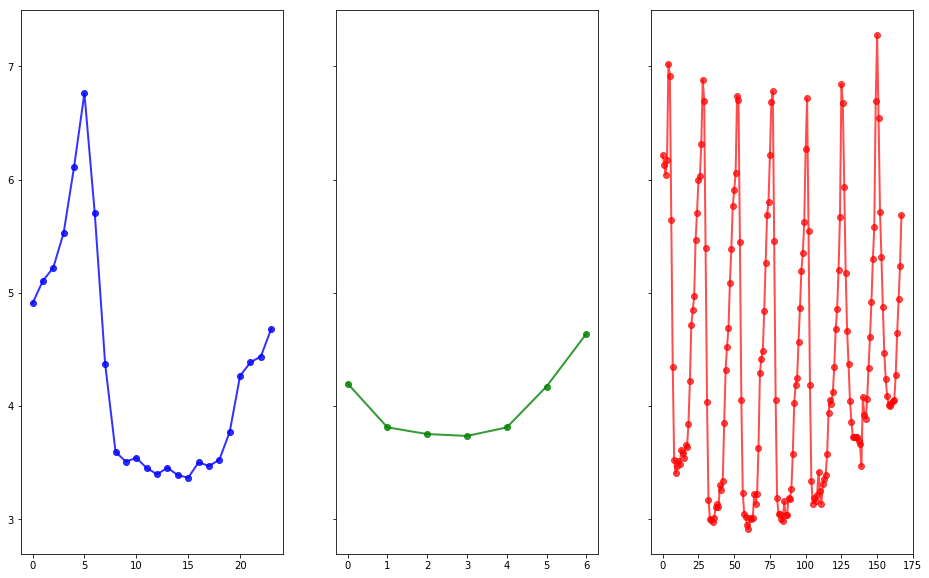

In [54]:
fig,ax=plt.subplots(ncols=3,sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'],'bo-',lw=2,alpha=.8)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'],'go-',lw=2,alpha=.8)
ax[2].plot(train.groupby('pickup_weekhour').mean()['avg_speed_h'],'ro-',lw=2,alpha=.7)